### 作業目的: 使用樹型模型進行文章分類

本次作業主利用[Amazon Review data中的All Beauty](https://nijianmo.github.io/amazon/index.html)來進行review評價分類(文章分類)

資料中將review分為1,2,3,4,5分，而在這份作業，我們將評論改分為差評價、普通評價、優良評價(1,2-->1差評、3-->2普通評價、4,5-->3優良評價)

In [1]:
import json
import re
import gzip
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
## 創建Lemmatizer
lemmatizer = WordNetLemmatizer()

In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 資料前處理
文本資料較為龐大，這裡我們取前10000筆資料來進行作業練習

In [3]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Beauty.json.gz

--2021-05-01 16:56:50--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47350910 (45M) [application/octet-stream]
Saving to: ‘All_Beauty.json.gz.3’

All_Beauty.json.gz. 100%[===================>]  45.16M  38.0MB/s    in 1.2s    

2021-05-01 16:56:52 (38.0 MB/s) - ‘All_Beauty.json.gz.3’ saved [47350910/47350910]



In [4]:
#load json data
all_reviews = []
with gzip.open('All_Beauty.json.gz') as f:
    for l in f:
        all_reviews.append(json.loads(l.strip()))
        
print(len(all_reviews))

all_reviews[0]

371345


{'asin': '0143026860',
 'overall': 1.0,
 'reviewText': 'great',
 'reviewTime': '02 19, 2015',
 'reviewerID': 'A1V6B6TNIC10QE',
 'reviewerName': 'theodore j bigham',
 'summary': 'One Star',
 'unixReviewTime': 1424304000,
 'verified': True}

In [7]:
#parse label(overall) and corpus(reviewText)
#transform labels: 1,2 --> 1 and 3 --> 2 and 4,5 --> 3
corpus = []
labels = []
i=0
while len(corpus)<10000:
    if 'reviewText' in all_reviews[i].keys() and 'overall' in all_reviews[i].keys():
        review = preprocessing_data(all_reviews[i]['reviewText'])
        if review != '':
            corpus.append(review)
            if all_reviews[i]['overall'] < 3:
                new_label = 1
            elif all_reviews[i]['overall'] == 3:
                new_label = 2
            else:
                new_label = 3
            labels.append(new_label)
            i+=1
        else: 
            i+=1
    else: 
        i+=1        

In [6]:
#preprocessing data
#remove email address, punctuations, and change line symbol(\n)

# Lemmatize with POS Tag
def get_wordnet_pos(word):
    """將pos_tag結果mapping到lemmatizer中pos的格式"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def preprocessing_data_with_lemmatize(sententce):
    pattern = '[\w.-]+@\w+\.\w+\.?\w+\.?\w+|\n|[\W_]'
    new_sententce = ' '.join([lemmatizer.lemmatize(re.sub(pattern,'',w),get_wordnet_pos(w)) for w in sententce.split()])

    return new_sententce

def preprocessing_data(sententce):
    pattern = '[\w.-]+@\w+\.\w+\.?\w+\.?\w+|\n|[\W_]'
    new_sententce = ' '.join([re.sub(pattern,'',w) for w in sententce.split()])

    return new_sententce

In [8]:
#split corpus and label into train and test
x_train, x_test, y_train, y_test = train_test_split(
                    corpus, labels, test_size=0.2, random_state=42, stratify=labels)

len(x_train), len(x_test), len(y_train), len(y_test)

(8000, 2000, 8000, 2000)

## TFIDF

In [9]:
#change corpus into vector
#you can use tfidf or BoW here

vectorizer = TfidfVectorizer(max_features=5500)
vectorizer.fit(x_train)


#transform training and testing corpus into vector form
tfidf_x_train = vectorizer.transform(x_train)
tfidf_x_test = vectorizer.transform(x_test)

In [10]:
tfidf_x_train.shape

(8000, 5500)

## BoW

In [16]:
#change corpus into vector
#you can use tfidf or BoW here

vectorizer2 = CountVectorizer(max_features=5500)
vectorizer2.fit(x_train)

#transform training and testing corpus into vector form
count_x_train = vectorizer2.transform(x_train)
count_x_test = vectorizer2.transform(x_test)

500th word shows up 64 times.
1000th word shows up 24 times.
2000th word shows up 8 times.
3000th word shows up 4 times.
3300th word shows up 3 times.
3500th word shows up 3 times.
4000th word shows up 2 times.
4500th word shows up 2 times.
4800th word shows up 2 times.
5000th word shows up 2 times.
5500th word shows up 1 times.
6000th word shows up 1 times.


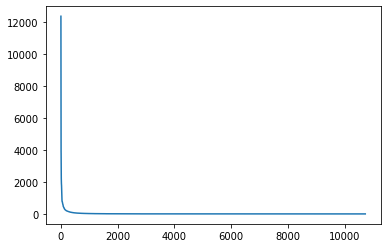

In [15]:
sum2 = count_x_train.toarray().sum(axis=0)
sum2.sort()
plt.plot(sum2[::-1])
index_list = [500,1000,2000,3000,3300,3500,4000,4500,4800,5000,5500,6000]
for index in index_list:
    print(f'{index}th word shows up {sum2[::-1][index]} times.')
#to change max_features

### 訓練與預測

### TFIDF

In [17]:
#build classification model (decision tree, random forest, or adaboost)
#start training
clf1 = DecisionTreeClassifier(random_state=0)
clf1.fit(tfidf_x_train,y_train)

clf2 = RandomForestClassifier(max_depth=6, random_state=0)
clf2.fit(tfidf_x_train,y_train)

clf3 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf3.fit(tfidf_x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [18]:
#start inference
y_pred1 = clf1.predict(tfidf_x_test)
y_pred2 = clf2.predict(tfidf_x_test)
y_pred3 = clf3.predict(tfidf_x_test)

In [19]:
#calculate accuracy
acc1 = accuracy_score(y_pred1, y_test)
print(f"DecisionTree: {acc1}")
acc2 = accuracy_score(y_pred2, y_test)
print(f"RandomForest: {acc2}")
acc3 = accuracy_score(y_pred3, y_test)
print(f"AdaBoost: {acc3}")

DecisionTree: 0.8705
RandomForest: 0.8935
AdaBoost: 0.9075


In [30]:
#calculate confusion matrix, precision, recall, and f1-score
print('Decision_Tree Tfidf')
print(classification_report(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))

Decision_Tree Tfidf
              precision    recall  f1-score   support

           1       0.41      0.41      0.41       137
           2       0.15      0.13      0.14        76
           3       0.93      0.94      0.93      1787

    accuracy                           0.87      2000
   macro avg       0.50      0.49      0.50      2000
weighted avg       0.87      0.87      0.87      2000

[[  56   12   69]
 [  11   10   55]
 [  68   44 1675]]


In [29]:
#calculate confusion matrix, precision, recall, and f1-score
print('RandomForest Tfidf')
print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))

RandomForest Tfidf
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       137
           2       0.00      0.00      0.00        76
           3       0.89      1.00      0.94      1787

    accuracy                           0.89      2000
   macro avg       0.30      0.33      0.31      2000
weighted avg       0.80      0.89      0.84      2000

[[   0    0  137]
 [   0    0   76]
 [   0    0 1787]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
#calculate confusion matrix, precision, recall, and f1-score
print('Adaboost Tfidf')
print(classification_report(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))

Adaboost Tfidf
              precision    recall  f1-score   support

           1       0.65      0.40      0.50       137
           2       0.30      0.09      0.14        76
           3       0.93      0.98      0.95      1787

    accuracy                           0.91      2000
   macro avg       0.63      0.49      0.53      2000
weighted avg       0.88      0.91      0.89      2000

[[  55    4   78]
 [   8    7   61]
 [  22   12 1753]]


### BoW

In [23]:
#build classification model (decision tree, random forest, or adaboost)
#start training
clf1_count = DecisionTreeClassifier(random_state=0)
clf1_count.fit(count_x_train,y_train)

clf2_count = RandomForestClassifier(max_depth=6, random_state=0)
clf2_count.fit(count_x_train,y_train)

clf3_count = AdaBoostClassifier(n_estimators=100, random_state=0)
clf3_count.fit(count_x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [24]:
#start inference
y_pred1_count = clf1_count.predict(count_x_test)
y_pred2_count = clf2_count.predict(count_x_test)
y_pred3_count = clf3_count.predict(count_x_test)

In [25]:
#calculate accuracy
acc1_count = accuracy_score(y_pred1_count, y_test)
print(f"DecisionTree: {acc1_count}")
acc2_count = accuracy_score(y_pred2_count, y_test)
print(f"RandomForest: {acc2_count}")
acc3_count = accuracy_score(y_pred3_count, y_test)
print(f"AdaBoost: {acc3_count}")

DecisionTree: 0.8695
RandomForest: 0.8935
AdaBoost: 0.911


In [26]:
#calculate confusion matrix, precision, recall, and f1-score
print('Decision_Tree BoW')
print(classification_report(y_test, y_pred1_count))
print(confusion_matrix(y_test, y_pred1_count))

Decision_Tree BoW
              precision    recall  f1-score   support

           1       0.39      0.35      0.37       137
           2       0.16      0.14      0.15        76
           3       0.93      0.94      0.93      1787

    accuracy                           0.87      2000
   macro avg       0.49      0.48      0.49      2000
weighted avg       0.86      0.87      0.87      2000

[[  48   14   75]
 [  10   11   55]
 [  65   42 1680]]


In [27]:
#calculate confusion matrix, precision, recall, and f1-score
print('RandomForest BoW')
print(classification_report(y_test, y_pred2_count))
print(confusion_matrix(y_test, y_pred2_count))

RandomForest BoW
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       137
           2       0.00      0.00      0.00        76
           3       0.89      1.00      0.94      1787

    accuracy                           0.89      2000
   macro avg       0.30      0.33      0.31      2000
weighted avg       0.80      0.89      0.84      2000

[[   0    0  137]
 [   0    0   76]
 [   0    0 1787]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
#calculate confusion matrix, precision, recall, and f1-score
print('Adaboost BoW')
print(classification_report(y_test, y_pred3_count))
print(confusion_matrix(y_test, y_pred3_count))

Adaboost BoW
              precision    recall  f1-score   support

           1       0.64      0.42      0.50       137
           2       0.25      0.04      0.07        76
           3       0.93      0.99      0.96      1787

    accuracy                           0.91      2000
   macro avg       0.61      0.48      0.51      2000
weighted avg       0.88      0.91      0.89      2000

[[  57    4   76]
 [  12    3   61]
 [  20    5 1762]]


由上述資訊可以發現, 模型在好評的準確度高(precision, recall都高), 而在差評的部分表現較不理想, 在普通評價的部分大部分跟差評搞混,
同學可以試著學習到的各種方法來提升模型的表現